In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Data Preprocessing

In [4]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [5]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

## Indexing with Time Series Data

In [6]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [7]:
y = furniture['Sales'].resample('MS').mean()

In [8]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing Furniture Sales Time Series Data

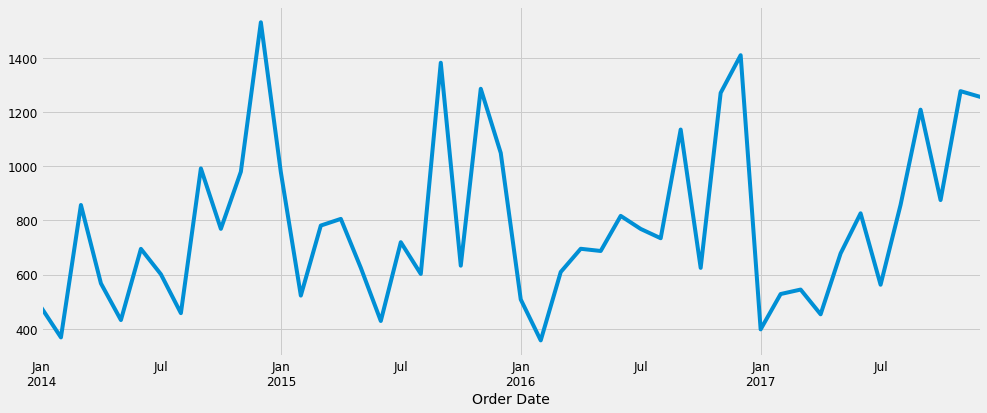

In [9]:
y.plot(figsize=(15, 6))
plt.show()

### Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

### We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

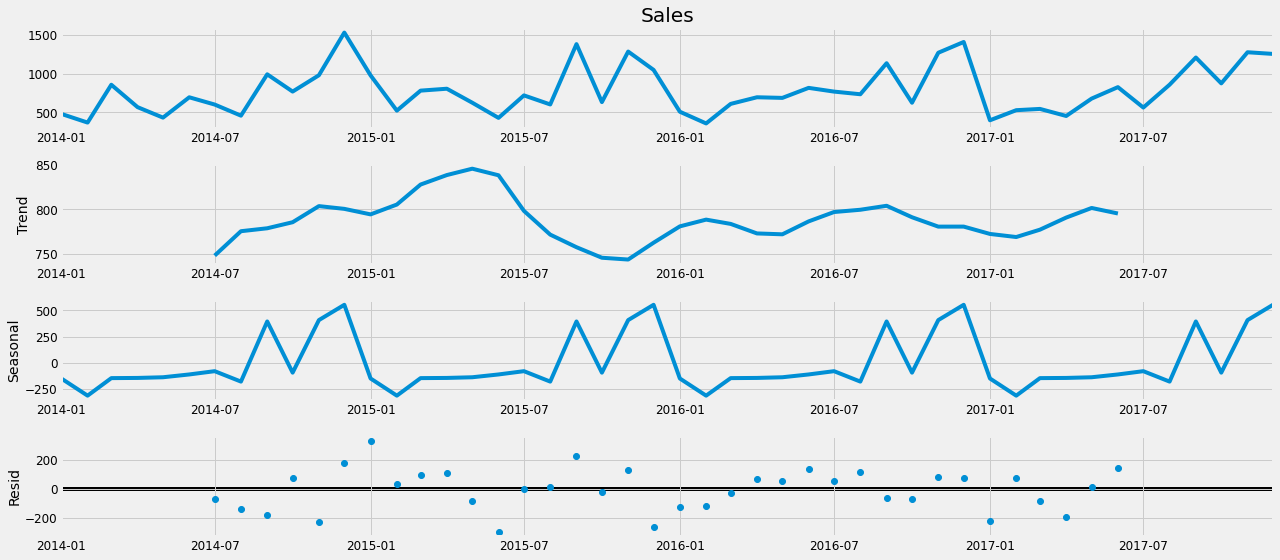

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

### One of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
### ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### This below step is for parameter Selection for furniture’s sales ARIMA Time Series Model. 
### Goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1291.5397466518418
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793669
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1259.6436149076847
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.248828030213
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758096
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2692.522076253822
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809162


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896733006
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.54421685134963


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2506.49765496247
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946866
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576435603
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1352.7177758455118
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679663
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1003.4137114431851
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.9113200151421
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817182


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:621.6781787596174
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482537
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58062333599605
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442641


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2113.6714686980595
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.75743684172403
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766214612396
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1358.5972450818679
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.20776751609714
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935197


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1126.0656453317874
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084599
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438075
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442185926


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2591.6269263585446
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195814901
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.3422193965895
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323877032


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2459.328399619176
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560021515735
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188229989
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:853.8204072944142
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619099
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658786717


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1117.085307925815
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013454264
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.3264992507484
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019834885


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1843.8421182123302
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.47626876097644
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939366
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660862


/home/souro/AI-ML-Training_Mindmajix/venv_aimltrn/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:772.9007789433033
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395375046
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661014472865


### The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 283.3661014472865. Therefore we should consider this to be optimal option.

## Fitting the ARIMA model

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0854      0.240      0.356      0.722      -0.385       0.556
ma.L1         -1.0000   3186.341     -0.000      1.000   -6246.114    6244.114
ar.S.L12       0.0274      0.512      0.053      0.957      -0.977       1.032
ma.S.L12      -1.0001   3185.999     -0.000      1.000   -6245.443    6243.443
sigma2      2.715e+04      0.050   5.41e+05      0.000    2.71e+04    2.71e+04


### Always run model diagnostics to investigate any unusual behavior.

### Below model diagnostics suggests that the model residuals are near normally distributed.

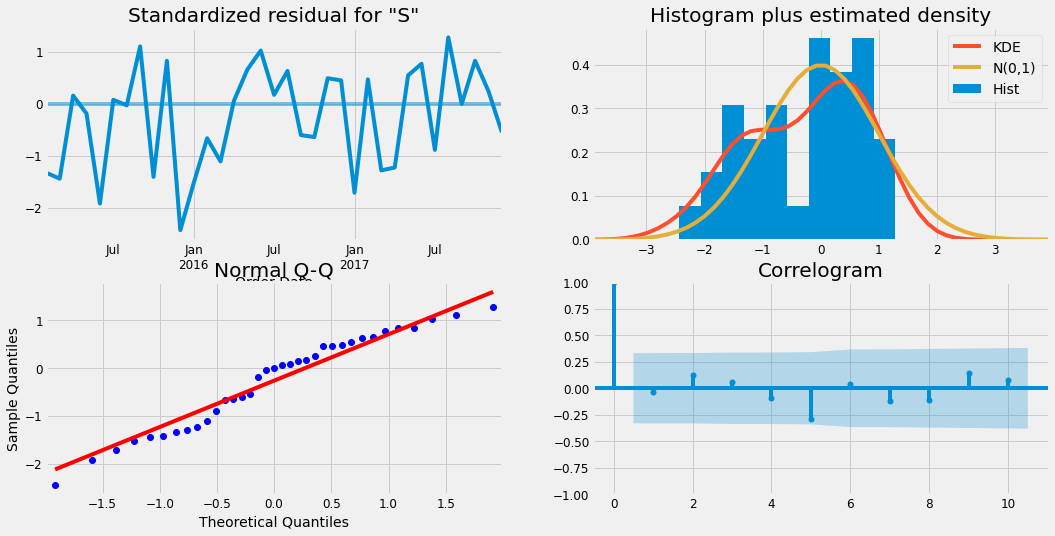

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

### To understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

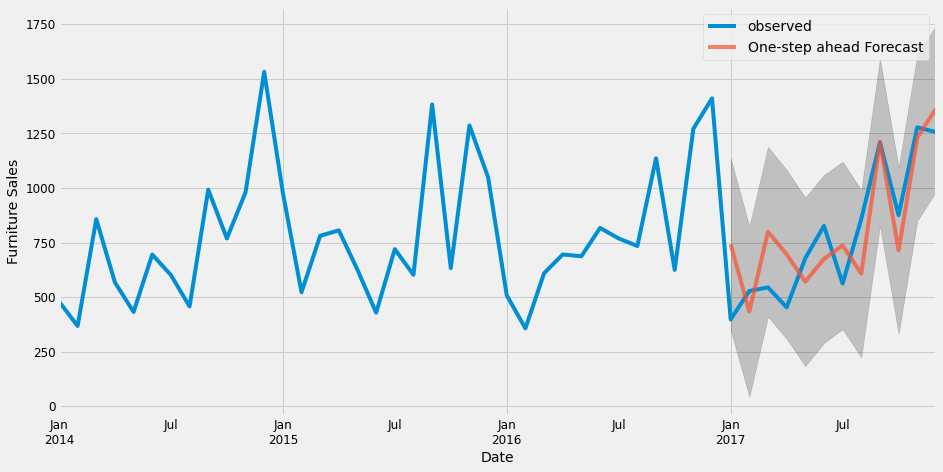

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34904.03


In [17]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 186.83


## Producing and visualizing forecasts

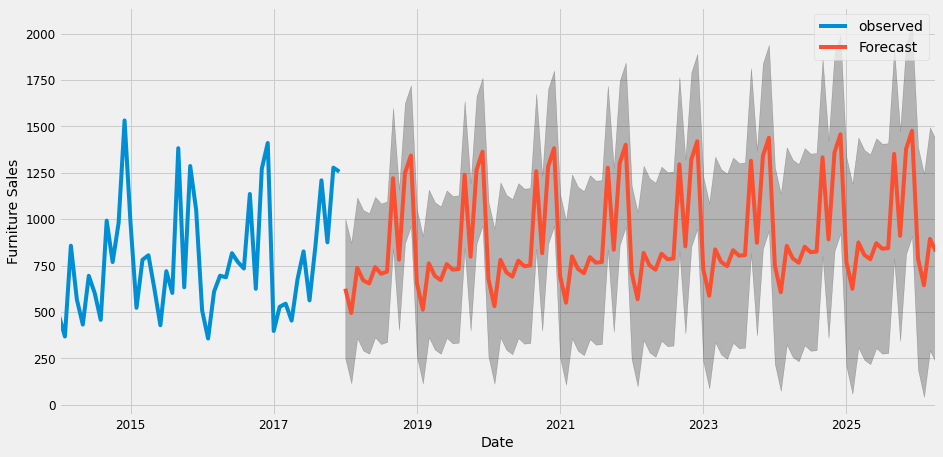

In [18]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.